# Clonal substructure of multi-regional tumors <a class='tocSkip'>

[Harald Detering](mailto:hdetering@uvigo.es)   
2018-05-11

# Objective

To simulate multi-regional tumor data, a clone tree is to be defined, and clones assigned to multiple regional samples.

Three different types of tumors will be considered here:
1. **low admixture**: clones segregate spatially, few samples share clones
1. **medium admixture**: higher admixture of clones in space, typically samples will share clones
1. **high admixture**: samples contain multiple clones

Ideally, the ancestral relationships between clones should be respected. I.e., clones that are more closely related should have a higher probability to occur in the same sample than distantly related clones (isolation by distance).

# Parameters

The following parameters will remain **fixed** in this simulation:
* no. _clones_: 6
* no. _samples_: 5

The **variable** parameters are:
* _clone phylogeny_: clone tree that defines relationships
* _prevalence matrix_: the frequency of each clone in each sample

In [1]:
n = 6 # number of clones
s = 5 # number of samples

# define labels for clones and regions
lbl_healthy = 'H'
lbl_clones  = ['C{}'.format(i+1) for i in range(n)]
lbl_regions = ['R{}'.format(i+1) for i in range(s)]

# Clone tree topology

The general steps to derive the clone tree are the following:
1. start with a set of nodes $S:=\{C_1\}$
2. for each clone $C_n \left(n\in\{2,\ldots,n\}\right)$: attach a new node to a random parent node from $S$

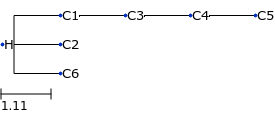

In [2]:
import random
import numpy as np
import ete3

# make reproducible random choices
seed = 3
random.seed(seed)
np.random.seed(seed)

def init_tree_nodes(n, labels, lbl_healthy='H', seed=None):
    '''Initialize tree topology (populating internal nodes).'''
    import random
    if seed is not None:
        random.seed(seed)
    
    tree = ete3.Tree(name=lbl_healthy, dist=0.0)
    nodes = [tree]
    for i in range(n):
        parent = random.choice(nodes)
        child = parent.add_child(name=lbl_clones[i], dist=1.0)
        nodes.append(child)
        
    return tree

# generate random clone tree topology
t = init_tree_nodes(n, lbl_clones, lbl_healthy, seed)

# define style for tree plotting
ts = ete3.TreeStyle()
#ts.title.add_face(ete3.TextFace('Clone Tree', fsize=14), column=0)
ts.show_leaf_name = False
def tree_node_layout(node):
    face = ete3.TextFace(node.name, tight_text=True, fsize=10)
    face.margin_top = 10
    face.margin_bottom = 10
    ete3.faces.add_face_to_node(face, node, column=0, position='branch-right')
ts.layout_fn = tree_node_layout

# show resulting tree
t.write(outfile='c6.tre', format=1, format_root_node=True)
t.render(file_name='%%inline', tree_style=ts)

## Alternative representation: Clones as leaf nodes

Some operations (e.g., calculation of distances between taxa) are more convenient if clones (taxa) are leaf nodes. An equivalent clone tree can be constructed by pulling out populated internal nodes as leafs with branch length of zero.

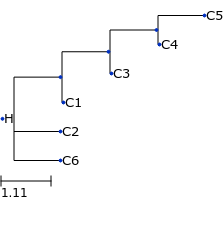

In [3]:
def reformat_int_to_leaf(tree, ignore_root=True):
    '''Reformat tree: pull out internal nodes as leafs.'''
    import ete3
    # make sure input is of the expected type
    assert type(tree) is ete3.Tree, 'Expected type of parameter "tree": ete3.Tree'
    
    for node in tree.traverse():
        if not node.is_leaf():
            # ignore root node if requested
            if node.is_root() and ignore_root:
                continue
            # create new leaf node
            node_leaf = ete3.TreeNode(name=node.name, dist=0)
            # mark populated internal node as unpopulated
            node.name = ''
            # attach leaf to internal node
            node.add_child(node_leaf)
    
    return tree

# re-format tree without internal nodes
t_ete = ete3.Tree('c6.tre', format=1)
t_bin = reformat_int_to_leaf(t_ete)
        
# write re-formatted tree to file
t_bin.write(outfile='c6.bin.tre', format=1, format_root_node=True)
t_bin.render(file_name='%%inline', tree_style=ts)

# Assign clones to samples

Clones are assigned to sampled regions as follows:

1. Pick the number of clones ($n_c$) to include in each sample
2. For each sample:
    1. Select an initial clone to be present in the sample
    2. Select the remaining ($n_c-1$) clones according to phylogenetic distance in the clone tree

## Number of clones per sample

The number of clones that are included in each sample follows a prior distribution which is different for each tumor type. The prior distributions are derived from a beta distribution, discretized into equally sized bins.

In [4]:
def get_beta_discrete(num_bins, a, b):
    from scipy.stats import beta
    import numpy as np
    
    # boundaries of bins
    limits = np.cumsum([0.0]+[1/num_bins]*num_bins)
    # get cumulative density for bin limits
    cdf = beta.cdf(limits, a, b)
    # get bin-wise probabilities
    bin_probs = np.diff(cdf)
    
    return bin_probs

def plot_bar(ax, x, y, title='Barplot', ylab='variable y', xlab='category'):
    import matplotlib.pyplot as plt
    
    x_pos = list(range(len(x)))
    ax.bar(x_pos, y, align='center', alpha=0.5)
    ax.grid()
    
    # set axis labels and title
    ax.set_ylabel(ylab)
    ax.set_xlabel(xlab)
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x)
    ax.set_title(title)
    
    # set height of the y-axis
    plt.ylim([0, (max(y)) * 1.1])

Different tumor types are characterized by different prior distributions for the number of clones to include in a given regional sample:

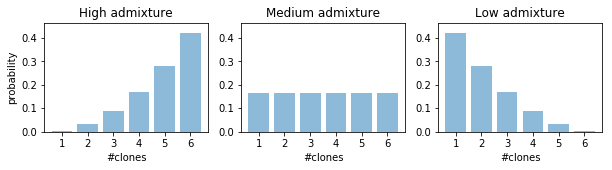

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

p_nclones_us = get_beta_discrete(n, 3, 1)
p_nclones_ms = get_beta_discrete(n, 1, 1)
p_nclones_hs = get_beta_discrete(n, 1, 3)

fig = plt.figure(figsize=(10,2))
#fig.suptitle('Prior distributions for number of clones per sample', 
#             fontsize=16, y=1.2, verticalalignment='top')
x = range(1, n+1)

# unstructured tumor
ax1 = fig.add_subplot(131)
plot_bar(ax1, x, p_nclones_us, title='High admixture', 
         xlab='#clones', ylab='probability')
ax1.grid(False)

# moderately structured tumor
ax2 = fig.add_subplot(132, sharey=ax1)
plot_bar(ax2, x, p_nclones_ms, title='Medium admixture', 
         xlab='#clones', ylab='')
ax2.grid(False)

# highly structured tumor
ax3 = fig.add_subplot(133, sharey=ax1)
plot_bar(ax3, x, p_nclones_hs, title='Low admixture', 
         xlab='#clones', ylab='')
ax3.grid(False)

plt.savefig("figures/Fig6.admixture_classes.pdf", format="pdf", bbox_inches='tight')
plt.savefig("figures/Fig6.admixture_classes.png", format="png", bbox_inches='tight')

## Pick clones for samples

In order to realize the constraints defined above, clones are chosen according to their degree of relatedness.

The general steps, for a given sample, are as follows:

1. Select an initial clone $c_i$ to be included in the sample.
2. Choose further clones until the desired number of clones is achieved. Importantly, the probability of a clone to be chosen is proportional to it's distance to $c_i$ in the clone tree.

In [6]:
def pick_related_nodes(n, dist, e_init):
    '''Choose a set of nodes related to an initial node.'''
    import numpy as np
    import pandas as pd
    
    # make sure input is of the expected type
    assert type(dist) is pd.DataFrame, 'Expected type of parameter "dist": pandas.DataFrame'
    
    # get distances for initial element
    d = dist.loc[e_init, dist.columns != e_init]
    # transform distances to similarities
    s = np.exp(-d)
    # transform similarities to probabilities (normalize)
    p = s / sum(s)
    # choose elements according to probabilities
    res = np.random.choice(p.index, n, replace=False, p=p)
    
    return res

## Distance measure

For this application, the distances between two clones is defined as the sum of branch lengths on the path between them.

In [7]:
def get_taxa_dist(tree_nwk):
    '''Get pairwise distances between taxa of a dendropy.Tree.'''
    import dendropy
    import pandas as pd
    
    # read tree from Newick string
    tree = dendropy.Tree.get(data=tree_nwk, schema='newick')
    
    # make sure input is of the expected type
    assert type(tree) is dendropy.Tree, 'Expected input: dendropy.Tree'
    # get leaf labels
    lbl = [x.label for x in tree.taxon_namespace]
    # calculate distance from root for nodes
    #dist = t.calc_node_root_distances(return_leaf_distances_only=False)
    # prepare distance matrix
    df = pd.DataFrame(0.0, index=lbl, columns=lbl)
    # determine distances
    m = tree.phylogenetic_distance_matrix()
    for i in range(len(lbl)):
        for j in range(i+1, len(lbl)):
            tax1 = tree.taxon_namespace[i]
            tax2 = tree.taxon_namespace[j]
            d = m.patristic_distance(tax1, tax2) 
            df.loc[tax1.label, tax2.label] = d
            df.loc[tax2.label, tax1.label] = d
    
    return df

with open('c6.bin.tre', 'rt') as f:
    t_bin_nwk = f.read()
dist = get_taxa_dist(t_bin_nwk)
dist
#t_ete.render(file_name='%%inline', tree_style=ts)

,C5,C4,C3,C1,C2,C6
C5,0.0,1.0,2.0,3.0,5.0,5.0
C4,1.0,0.0,1.0,2.0,4.0,4.0
C3,2.0,1.0,0.0,1.0,3.0,3.0
C1,3.0,2.0,1.0,0.0,2.0,2.0
C2,5.0,4.0,3.0,2.0,0.0,2.0
C6,5.0,4.0,3.0,2.0,2.0,0.0


# Clone prevalence

Given the clone tree, the next task is to configure the **prevalence matrix**, i.e., at which cellular frequency each clone occurs in each sample.

## Assumptions

1. **Isolation by distance** (IBD): Clones that are distantly related should rarely be present in the same region. 

## Constraints

1. The prevalence matrix should reflect the **type of tumor** to be simulated, i.e., low, medium or high admixture.
2. **Each clone should be present** in at least one sample.
3. **Respect IBD**: Closely related clones should have a higher probability to appear in the same sample than distantly related ones. (Does not apply to unstructured tumors.)

## Prior distribution

In the absence of a specific spatial model, the clones present in a given sample can occur in any mixture proportion. We modelize this indifference as a flat dirichlet prior.

**Note**: This can lead to clones being excluded because their prevalence is below the detectability threshold.

In [8]:
def pick_prevalence_unbiased(n):
    import numpy as np
    import pandas as pd
    
    prev = np.random.dirichlet([1]*n)
    return prev

# Wrapping up: Bundle workflow into single method

This method performs the workflow steps outlined above and assures consistency of the generated scenario.

**Constraint:** Each clone should be included in at least one sample. Therefore, we employ *rejection sampling*, repeating the process of clone selection until the constraint is satisfied.

In [9]:
def get_tumor_setup(num_clones, num_samples, tumor_type, seed=None):
    '''Generate configuration for a tumor sequencing dataset.
    
    A setup comprises multiple clones and sampling regions and
    returns a clone tree and prevalence matrix for the specified
    input parameters.
    
    Parameters
    ---
    :num_clones:  Number of clones present in the tumor.
    :num_samples: Number of tumor regions sampled.
    :tumor_type:  One of "hs", "ms", "us" (highly, moderately or unstructured).
    :seed:        Random seed.
    
    Output
    ---
    1. Clone tree in Newick notation. (string)
    2. Prevalence matrix (sample X clone). (DataFrame)
    3. Sampling scheme. (DataFrame)
    4. Prior used for selection of shared clones per sample. (DataFrame)
    '''
    
    #import random
    import numpy as np
    import pandas as pd
    import dendropy as dp
    import ete3

    # make reproducible random choices
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    # define labels for clones and samples
    lbl_clones  = ['C{}'.format(i+1) for i in range(num_clones)]
    lbl_regions = ['R{}'.format(i+1) for i in range(num_samples)]

    # init random clone tree topology
    tree_ete = init_tree_nodes(num_clones, lbl_clones)
    tree_nwk = tree_ete.write(format=1, format_root_node=True)
    tree_ete_leaf = reformat_int_to_leaf(tree_ete)
    tree_nwk_leaf = tree_ete_leaf.write(format=1, format_root_node=True)
    dist = get_taxa_dist(tree_nwk_leaf)
    
    # get prior probabilities for number of clones per sample
    assert tumor_type in ['hs', 'ms', 'us'], 'Tumor type must be "hs", "ms" or "us".'
    if tumor_type == 'hs':
        p_nclones = get_beta_discrete(num_clones, a=1, b=5)
    elif tumor_type == 'ms':
        p_nclones = get_beta_discrete(num_clones, a=1, b=1)
    elif tumor_type == 'us':
        p_nclones = get_beta_discrete(num_clones, a=5, b=1)
    
    # choose number of clones for each sample:
    nclones = np.random.choice(range(1,num_clones+1), num_samples, p=p_nclones)
    df_sampling = pd.DataFrame(data = nclones,
                               index = lbl_regions,
                               columns = ['nclones'])
    
    # choose clones to include in each sample
    all_clones_sampled = False
    while not all_clones_sampled:
        lst_clones = []
        set_clones = set()
        for idx, row in df_sampling.iterrows():
            # get number of clones selected before
            nclones = row['nclones']
            # choose random initial clone
            c_init = np.random.choice(lbl_clones)
            sel_clones = [c_init]
            sel_clones += list(pick_related_nodes(nclones-1, dist, c_init))
            lst_clones.append(sel_clones)
            set_clones.update(sel_clones)
        all_clones_sampled = ( len(set_clones) == num_clones )
    df_sampling['sel_clones'] = pd.Series(lst_clones, index=df_sampling.index)
    
    # assign prevalence for clones in each sample
    df_prev = pd.DataFrame(0, index=lbl_regions, columns=lbl_clones, dtype=float)
    for idx, row in df_sampling.iterrows():
        p = np.random.dirichlet([1]*row['nclones'])
        df_prev.loc[idx, row['sel_clones']] = p
    
    # return result
    return (tree_nwk, df_prev, df_sampling, p_nclones)

# Show case: apply rules to different tumor types

## High admixture (unstructured tumor)

The simplest case is an highly admixed tumor. Here,
* it should be much more likely that many clones are shared within each sample and 
* clone prevalences can be sampled from a *flat dirichlet prior*:

In [10]:
tree_nwk, df_prev, df_sampling, p_nclones = get_tumor_setup(n, s, 'us')
# save scenario to files
with open('c6_r5_us.tree.nwk', 'wt') as f:
    f.write('{}\n'.format(tree_nwk))
df_prev.to_csv('c6_r5_us.prev.csv')

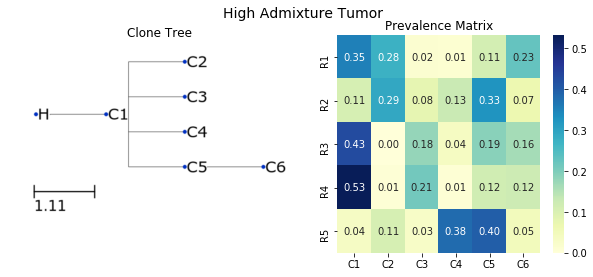

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

tree_ete = ete3.Tree(tree_nwk, format=1)
tree_ete.render(file_name='clone_tree_us.png', tree_style=ts, w=4, units='in', dpi=150)
tree_img = mpimg.imread('clone_tree_us.png')

fig = plt.figure(figsize=(10,4))
fig.suptitle('High Admixture Tumor', fontsize=14)

# plot clone tree
ax1 = fig.add_subplot(121)
plt.imshow(tree_img, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Clone Tree')

# plot prevalence matrix as heatmap
ax2 = fig.add_subplot(122)
ax2 = sns.heatmap(df_prev, cmap="YlGnBu", annot=True, fmt='0.2f')
ax2.set_title('Prevalence Matrix')

plt.savefig("c6_r4_us.png", bbox_inches='tight')

## Low admixture (highly structured tumor)

A tumor of low admixture implies little sharing of clones between samples. However, when sharing occurs, closely related clones should be sampled together.

By selecting an intermediate node in the clone tree and including all clones belonging to the corresponding subtree, a phylogenetically consistent sampling (satisfying IBD assumption) can be generated.

To account for the fact that the tumor is highly structured, an internal node close to the leaves must be chosen, i.e., a node with small height.

In [12]:
tree_nwk, df_prev, df_sampling, p_nclones = get_tumor_setup(n, s, 'hs')
# save scenario to files
with open('c6_r5_hs.tree.nwk', 'wt') as f:
    f.write('{}\n'.format(tree_nwk))
df_prev.to_csv('c6_r5_hs.prev.csv')

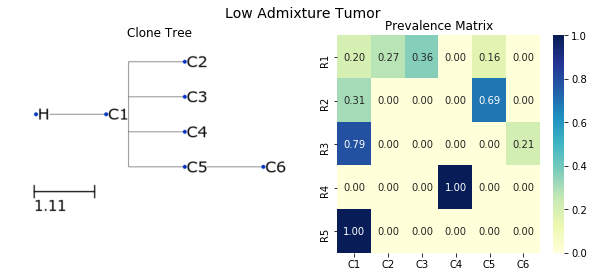

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

tree_ete = ete3.Tree(tree_nwk, format=1)
tree_ete.render(file_name='clone_tree_hs.png', tree_style=ts, w=4, units='in', dpi=150)
tree_img = mpimg.imread('clone_tree_hs.png')

fig = plt.figure(figsize=(10,4))
fig.suptitle('Low Admixture Tumor', fontsize=14)

# plot clone tree
ax1 = fig.add_subplot(121)
plt.imshow(tree_img, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Clone Tree')

# plot prevalence matrix as heatmap
ax2 = fig.add_subplot(122)
ax2 = sns.heatmap(df_prev, cmap="YlGnBu", annot=True, fmt='0.2f')
ax2.set_title('Prevalence Matrix')

plt.savefig("c6_r4_hs.png", bbox_inches='tight')

## Medium admixture (moderately structured tumor)

Medium admixture tumors should have more sharing of clones between samples than highly structured tumors. In order to simulate this structure, choose with higher probability intermediate nodes that are located higher within the clone tree.

In [14]:
tree_nwk, df_prev, df_sampling, p_nclones = get_tumor_setup(n, s, 'ms')
# save scenario to files
with open('c6_r5_ms.tree.nwk', 'wt') as f:
    f.write('{}\n'.format(tree_nwk))
df_prev.to_csv('c6_r5_ms.prev.csv')

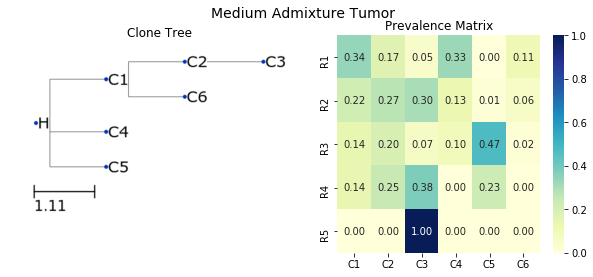

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

tree_ete = ete3.Tree(tree_nwk, format=1)
tree_ete.render(file_name='clone_tree_ms.png', tree_style=ts, w=4, units='in', dpi=150)
tree_img = mpimg.imread('clone_tree_ms.png')

fig = plt.figure(figsize=(10,4))
fig.suptitle('Medium Admixture Tumor', fontsize=14)

# plot clone tree
ax1 = fig.add_subplot(121)
plt.imshow(tree_img, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Clone Tree')

# plot prevalence matrix as heatmap
ax2 = fig.add_subplot(122)
ax2 = sns.heatmap(df_prev, cmap="YlGnBu", annot=True, fmt='0.2f')
ax2.set_title('Prevalence Matrix')

plt.savefig("c6_r4_ms.png", bbox_inches='tight')